# Titanic Exercise

In [5]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read training data

In [6]:
train = pd.read_csv('datasets/titanic_train.csv')

## Preprocess the data

### Impute passenger age based on class

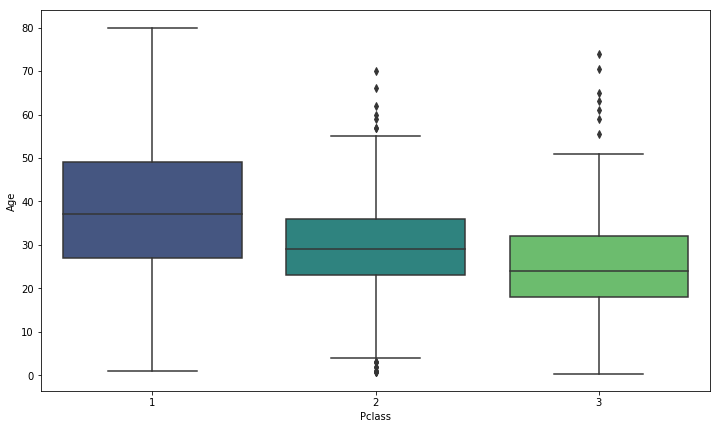

In [7]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='viridis')

### We can see that older passengers tend to be in class 1, while younger passengers are in class 3. Let's impute the average age for the missing age values based on passenger class.

In [8]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

In [9]:
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)
train.drop('Cabin',axis=1,inplace=True)
train.dropna(inplace=True)
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Embarked  
0      0         A/5 21171   7.2500        S  
1      0          PC 17599  71.2833        C  
2      0  STON/O2. 3101282   7.9250        S  
3      0            113803  53.1000        S  
4      0            373450   8.0500        S

## Extract titles feature from Name

### The Name column contains information about passenger titles, e.g. if a person is married or not and how old she might be. Let's extract this information and add it as a feature. Code courtesy of this post: https://www.kaggle.com/manuelatadvice/feature-engineering-titles

In [10]:
def get_title(name):
    if '.' in name:
        return name.split(',')[1].split('.')[0].strip()
    else:
        return 'Unknown'

In [11]:
# A list with the all the different titles
titles = sorted(set([x for x in train.Name.map(lambda x: get_title(x))]))
print('Different titles found on the dataset:')
print(len(titles), ':', titles)
print()

Different titles found on the dataset:
17 : ['Capt', 'Col', 'Don', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Master', 'Miss', 'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms', 'Rev', 'Sir', 'the Countess']



In [12]:
# Normalize the titles, returning 'Mr', 'Master', 'Miss' or 'Mrs'
def replace_titles(x):
    title = x['Title']
    if title in ['Capt', 'Col', 'Don', 'Jonkheer', 'Major', 'Rev', 'Sir']:
        return 'Mr'
    elif title in ['the Countess', 'Mme', 'Lady']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

In [13]:
# Lets create a new column for the titles
train['Title'] = train['Name'].map(lambda x: get_title(x))

# And replace the titles, so the are normalized to 'Mr', 'Miss' and 'Mrs'
train['Title'] = train.apply(replace_titles, axis=1)

# The name isn't helpful anymore, let's drop this column
train.drop('Name', axis=1, inplace=True)

## Convert categorical variables

### Dummy encode the categorical variables so that the neural network can make sense of them.

In [14]:
sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)
title = pd.get_dummies(train['Title'],drop_first=True)

In [15]:
train.drop(['Sex','Embarked','Ticket', 'PassengerId', 'Title'],axis=1,inplace=True)
train = pd.concat([train,sex,embark,title],axis=1)
train.head()

Survived  Pclass   Age  SibSp  Parch     Fare  male  Q  S  Miss  Mr  Mrs
0         0       3  22.0      1      0   7.2500     1  0  1     0   1    0
1         1       1  38.0      1      0  71.2833     0  0  0     0   0    1
2         1       3  26.0      0      0   7.9250     0  0  1     1   0    0
3         1       1  35.0      1      0  53.1000     0  0  1     0   0    1
4         0       3  35.0      0      0   8.0500     1  0  1     0   1    0

## Apply Standard Scaler to Age and Fare

### The age and fare values are not scaled. Scaling helps the neural network converge faster.

In [16]:
from sklearn.preprocessing import StandardScaler
age = train['Age'].values.reshape(889,1)
scaler = StandardScaler()
scaler.fit(age)
scaled_age = scaler.transform(age)
train['Age'] = scaled_age

fare = train['Fare'].values.reshape(889,1)
scaler = StandardScaler()
scaler.fit(fare)
scaled_fare = scaler.transform(fare)
train['Fare'] = scaled_fare
train.head()

Survived  Pclass       Age  SibSp  Parch      Fare  male  Q  S  Miss  Mr  \
0         0       3 -0.531670      1      0 -0.500240     1  0  1     0   1   
1         1       1  0.680232      1      0  0.788947     0  0  0     0   0   
2         1       3 -0.228695      0      0 -0.486650     0  0  1     1   0   
3         1       1  0.453001      1      0  0.422861     0  0  1     0   0   
4         0       3  0.453001      0      0 -0.484133     1  0  1     0   1   

   Mrs  
0    0  
1    1  
2    0  
3    1  
4    0

### The training data now looks fine and ready to be evaluated by the neural network.

# Apply neural network

In [17]:
from sklearn.model_selection import train_test_split
X = train.drop('Survived', axis=1)
y = train['Survived']

# Create training and test splits
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)


## Build model

In [95]:
# build model

from keras.layers import Input, Dense, Dropout
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model

input_dim = X_tr.shape[1]

input_layer = Input(shape=(input_dim, ))
model = Dense(5, activation="relu")(input_layer)
#model = Dropout(0.3)(model)
#model = Dense(2, activation="relu")(model)
#model = Dropout(0.3)(model)
model = Dense(1, activation='sigmoid')(model)
mlp_model = Model(inputs=input_layer, outputs=model)

In [96]:
# CONSTANTS
BATCH_SIZE = 20
EPOCHS = 100

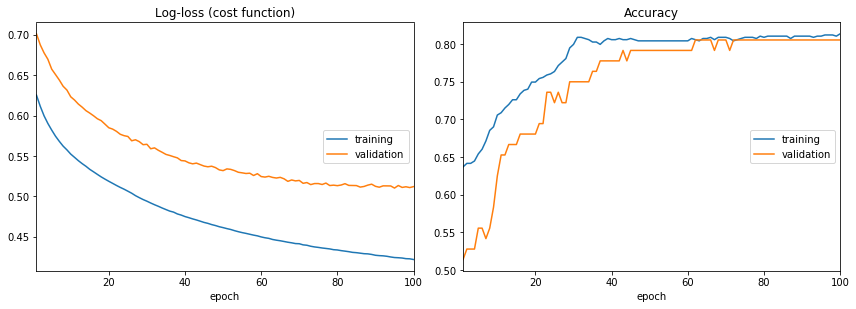

In [97]:
# train model

from livelossplot import PlotLossesKeras

mlp_model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy'])

checkpointer = ModelCheckpoint(
    filepath="mlp_model.h5",
    verbose=0,
    save_best_only=True)

history = mlp_model.fit(
    X_tr,
    y_tr,
    validation_split=0.10,
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    verbose=0, 
    callbacks=[checkpointer, PlotLossesKeras()]).history

In [98]:
# load the saved best model
model = load_model('mlp_model.h5')

In [99]:
# predictions on training set
pred_train = model.predict(X_tr)

In [100]:
# predictions on test set
evaluation = model.evaluate(X_tr, y_tr, batch_size=BATCH_SIZE, verbose=0)

print("MODEL PERFORMANCE ON TRAINING SET: " + str(round(evaluation[1]*100)) + "%")

MODEL PERFORMANCE ON TRAINING SET: 81.0%


In [101]:
# print test set accuracy
evaluation = model.evaluate(X_te, y_te, batch_size=BATCH_SIZE, verbose=0)

print("MODEL PERFORMANCE ON TEST SET: " + str(round(evaluation[1]*100)) + "%")

MODEL PERFORMANCE ON TEST SET: 82.0%


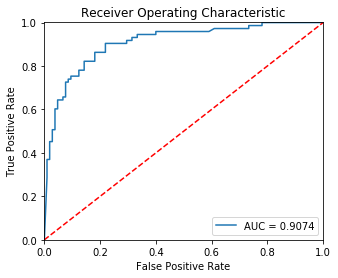

In [102]:
# roc curve
from sklearn.metrics import (confusion_matrix, auc, roc_curve)

fpr, tpr, thresholds = roc_curve(y_te, pred_test)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

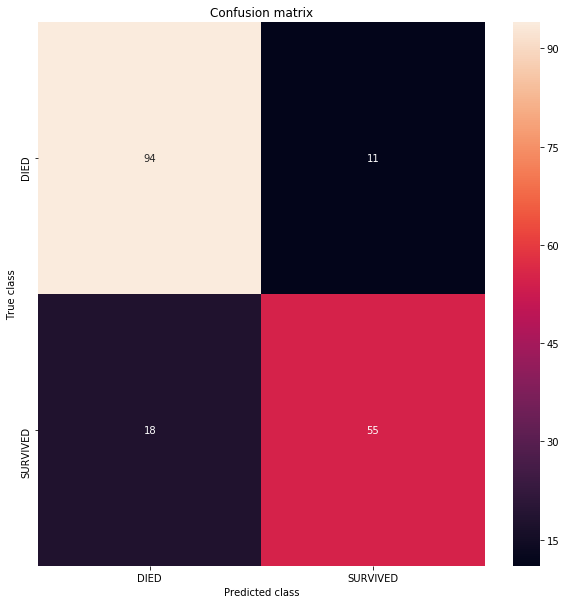

In [103]:
# look at results IN DETAIL
# confusion matrix

threshold = 0.5
LABELS = ['DIED','SURVIVED']

y_pred = [1 if e > threshold else 0 for e in pred_test]
conf_matrix = confusion_matrix(y_te, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()